In [409]:
import pandas as pd
import numpy as np
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import shapely.ops as so
import matplotlib.patches as mpatches
import joblib
import dataframe_image as dfi

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

streetview = pd.read_csv('../MorrisCountyImages/csv/morris_pred_grouped.csv')
census = pd.read_csv('../CensusScrap/censusMorrisCleaned.csv')
bps = pd.read_csv('../BPS/morrisCountyBPS.csv')
greenSpace = pd.read_csv('../GreenSpace/green_space_estimates.csv')

towns_shapefile = "../MorrisCountyImages/Municipalities/Municipalities.shp"
townSize = gpd.read_file(towns_shapefile).reset_index()
townSize = townSize.to_crs(4326)[["Label","GISAcres"]].sort_values(by="Label", ascending=True)
townSize.GISAcres = np.int64(townSize.GISAcres)

## 1.) Merge datasets

In [255]:
combined = pd.merge(census, bps, on='town', how='inner').merge(streetview, on='town', how='inner')
for col in combined.columns[1:]:
    if combined[col].dtype == object:
        combined[col] = [np.int64(x.replace(',','').replace('-','0').replace('+','')) for x in combined[col]] 
        ### Convert string with commas to int64
combined = pd.merge(combined, townSize, left_on='town', right_on='Label', how='inner').drop('Label',axis=1)
combined = pd.merge(combined, greenSpace, on='town', how='left') # greenSpace doesn't have all towns
combined.fillna(0, inplace=True)

#### Combing columns to standardize values to remove town size as a factor, and drop unhelpful features

In [257]:
combined["OccupiedHousingUnits"] = combined["Occupied housing units"]/combined["TOTAL_UNITS"]
combined["OwnerOccupied"] = combined["Owner-occupied"]/combined["TOTAL_UNITS"]
combined["RenterOccupied"] = combined["Renter-occupied"]/combined["TOTAL_UNITS"]
combined["BuiltRecently"] = combined[['Built 2020 or later', 'Built 2010 to 2019', 'Built 2000 to 2009',
       'Built 1990 to 1999', 'Built 1980 to 1989', 'Built 1970 to 1979',
       'Built 1960 to 1969', 'Built 1950 to 1959', 'Built 1940 to 1949',
       'Built 1939 or earlier']].T.sum()/combined["TOTAL_UNITS"]
combined["AvgUnitValue"] = combined["TOTAL_VALUE"]//combined["TOTAL_UNITS"]
combined["ParkSpace"] = combined["Park_Size_Acres"]/combined["GISAcres"]

combined.drop(['Occupied housing units', 'Owner-occupied', 'Renter-occupied',
       'Built 2020 or later', 'Built 2010 to 2019', 'Built 2000 to 2009',
       'Built 1990 to 1999', 'Built 1980 to 1989', 'Built 1970 to 1979',
       'Built 1960 to 1969', 'Built 1950 to 1959', 'Built 1940 to 1949',
       'Built 1939 or earlier', 'TOTAL_UNITS', 'TOTAL_VALUE', 'UNITS_1_UNIT',
       'UNITS_2_UNITS', 'UNITS_3_4_UNITS', 'UNITS_5_UNITS', 'VALUE_1_UNIT',
       'VALUE_2_UNITS', 'VALUE_3_4_UNITS', 'VALUE_5_UNITS','GISAcres','Park_Size_Acres'],axis=1,inplace=True)

In [410]:
combined

,town,Median Home Value,Median Gross Rent,pred,SUM_BLACK_SVC,SUM_WHITE_SVC,SUM_HISP_SVC,SUM_HHILOWSVCA,SUM_HHIMEDSVCA,SUM_HHIHIGHSVCA,OccupiedHousingUnits,OwnerOccupied,RenterOccupied,BuiltRecently,AvgUnitValue,ParkSpace
0,Boonton Town,468900,1637,2,0.051274,0.629349,0.156048,0.104875,0.084345,0.191242,0.580514,0.326475,0.254038,0.618772,112566,0.058152
1,Boonton Township,683600,2155,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.262073,0.234955,0.027117,0.284547,247909,0.000000
2,Butler Borough,396700,1466,4,0.015903,0.696456,0.215385,0.117027,0.132757,0.168712,0.643266,0.438204,0.205062,0.650841,87567,0.002840
3,Chatham Borough,944600,2201,2,0.009262,0.777167,0.069036,0.036403,0.038449,0.261066,0.416314,0.349421,0.066892,0.431555,234294,0.021895
4,Chatham Township,1025300,2359,0,0.018290,0.776124,0.069616,0.035588,0.053311,0.263434,0.361714,0.303449,0.058265,0.370172,283555,0.102636
5,Chester Borough,614700,1508,2,0.002604,0.751736,0.171007,0.088542,0.064236,0.220486,0.090527,0.067196,0.023332,0.092705,116210,0.014161
6,Chester Township,776100,0,3,0.004405,0.770925,0.140969,0.061674,0.061674,0.242291,0.324193,0.312970,0.011223,0.341793,231164,0.003851
7,Denville Township,512700,1769,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.414784,0.349516,0.065268,0.449968,137177,0.000000
8,Dover Town,316900,1698,1,0.040533,0.193569,0.715091,0.101973,0.091981,0.122137,0.713222,0.316457,0.396764,0.742435,91248,0.259522
9,East Hanover Township,669000,3033,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.334589,0.314812,0.019777,0.343750,119778,0.000000


## 2.) Create an unsupervised clustering model
#### Using random weight factor after standardizing to influence the feature weights by scaling the values among each other

In [385]:
random_weight = np.random.uniform(low=0.25, high=1.0, size=(15,))

X = combined.copy().drop(['town'],axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled)

new_X_scaled = pd.DataFrame()
for i in range(X_scaled_df.shape[1]):
    new_X_scaled[i] = X_scaled_df[i]*random_weight[i]

In [392]:
random_weight

array([0.59208689, 0.96458258, 0.84435617, 0.65421567, 0.48946075,
       0.2944736 , 0.49866217, 0.4490246 , 0.91653138, 0.82369686,
       0.40860639, 0.63348241, 0.86123992, 0.35592105, 0.40986996])

In [378]:
#KMeans
km = KMeans(n_clusters=2, random_state=43)
km.fit(new_X_scaled)
km.predict(new_X_scaled)
km_labels = km.labels_;

In [379]:
result = combined.copy()
result['labels'] = km_labels

## 3.) Interpreting clustering results

In [395]:
result0 = result[result.labels == 0]
result1 = result[result.labels == 1]
numOfTowns = pd.DataFrame(np.array([["Result0",result0.town.nunique()],["Result1",result1.town.nunique()]]))
numOfTowns

,0,1
0,Result0,22
1,Result1,17


In [381]:
table = pd.DataFrame(index=['result0','result1'])

for col in combined.columns[1:]:
    if (combined[col].dtype == float and col != "Park_Size_Acres"):
        # floats - mean
        new_col = [result0[col].mean(),result1[col].mean()]
    elif col in ["Median Home Value","Median Gross Rent"]:
        # int - median
        new_col = [np.int64(result0[col].median()),np.int64(result1[col].median())]
    else:
        new_col = [result0[col].sum(),result1[col].sum()]
    table[col] = new_col
table

,Median Home Value,Median Gross Rent,pred,SUM_BLACK_SVC,SUM_WHITE_SVC,SUM_HISP_SVC,SUM_HHILOWSVCA,SUM_HHIMEDSVCA,SUM_HHIHIGHSVCA,OccupiedHousingUnits,OwnerOccupied,RenterOccupied,BuiltRecently,AvgUnitValue,ParkSpace
result0,535700,2184,47,0.023140,0.729144,0.144107,0.079173,0.081655,0.22782,0.349612,0.263788,0.085823,0.364795,2963076,0.119575
result1,621600,1698,30,0.008088,0.215768,0.089035,0.026489,0.032440,0.06795,0.848594,0.578382,0.270212,0.880856,3223085,0.023576


In [408]:
# Saving
joblib.dump(km, './clusteringModel.pkl')
dfi.export(pd.DataFrame(random_weight).style,'../Figures/tables/randomWeights.png')
dfi.export(table.style,'../Figures/tables/tableClusteringGrouped.png')
dfi.export(numOfTowns.style,'../Figures/tables/numberOfTownsCluster.png')

['./clusteringModel.pkl']

#### We obviously need to classify the clustering labels ourselves. From the grouped town dataframe, we could easily explore the clustering of all the features. We could see from most features including streetview changes, median gross rent and AvgUnitValue that Result0 is exhibiting signs of rural gentrification.

## 4.) Prediction plot

In [405]:
color_labels = ['lightcoral','cornflowerblue']
color_patches = [mpatches.Patch(color=color_labels[x]) for x in range(2)]
legend_labels = []
if table.pred.values[0] > table.pred.values[1]:
    legend_labels.append('Gentrifying')
    legend_labels.append('Not Gentrifying')
else:
    legend_labels.append('Not Gentrifying')
    legend_labels.append('Gentrifying')

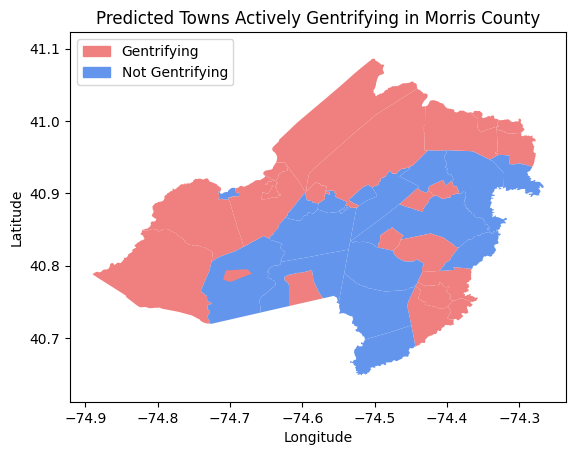

In [406]:
towns_shapefile = "../MorrisCountyImages/Municipalities/Municipalities.shp"
gdf = gpd.read_file(towns_shapefile).reset_index()
gdf = gdf.to_crs(4326)


fig,ax = plt.subplots()
ax.set_aspect('equal','datalim')


for i in range(39):
    # Plot polygon by color
    town = gdf.loc[gdf.index[i]]
    result_row = result[result.town == town.Label]
    if town.geometry.geom_type == 'Polygon':
        x, y = town.geometry.exterior.xy
        ax.fill(x, y, alpha=1, fc=color_labels[result_row.labels.values[0]], ec='none')
    elif town.geometry.geom_type == 'MultiPolygon':
        new_shape = so.unary_union(town.geometry)
        for geom in new_shape.geoms:
            x, y = geom.exterior.xy
            ax.fill(x, y, alpha=1, fc=color_labels[result_row.labels.values[0]], ec='none')
    
plt.legend(handles=color_patches, labels=legend_labels, loc='upper left')
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.title("Predicted Towns Actively Gentrifying in Morris County")
plt.savefig("../Figures/plots/predictedTownsMorris.png", bbox_inches='tight');
plt.show();